In [168]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
import geopandas as gpd
import xarray as xr
import rioxarray
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import matplotlib as mpl
from cmcrameri import cm
import cartopy.feature as cf
import regionmask
shp_pan = gpd.read_file(r'Data\shapefiles\panamz.geojson')
folder_metric = r'Data\Datasets\amz\map\trend'
datasets = ['cru', 'gpcc', 'chirps','imerg', 'terra', 'era_land', 'jra55','merra2']
datasets_names = ['CRU', 'GPCC', 'CHIRPS','IMERG-V6', 'TerraClimate', 'ERA5-Land', 'JRA55','MERRA2']
stations = gpd.read_file(r'Data\Datasets\amz\map\stations.geojson')
regions = gpd.read_file(r'Data\shapefiles\ANA_amz.geojson', driver='GeoJSON')
regions_mask = regionmask.from_geopandas(regions, names='Region')

In [169]:
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 18})
regions_list = ['Western', 'Northern', 'Southern', 'Eastern']
regions_replace = { 0:'Southern', 1:'Eastern',2:'Western', 3:'Northern'}
wong = ['#882255','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#999999']
wong_b = ['#882255','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#000000']
hue_order = datasets_names.copy()
hue_order.append('Stations')
legend_elements = [Line2D([0], [0],  marker='s', color='w', label=hue_order[i], markerfacecolor=wong[i], markersize=12) for i in range(len(wong))]
legend_elements_b = [Line2D([0], [0],  marker='s', color='w', label=hue_order[i], markerfacecolor=wong_b[i], markersize=12) for i in range(len(wong_b))]
letters_22 = ['j)', 'k)', 'l)', 'm)']


In [170]:
ds_dict = {}
for i, dataset in enumerate(datasets):
    ds = xr.open_dataset(os.path.join(folder_metric, dataset + '.nc'))
    #create mask from regions
    mask = regions_mask.mask(ds, lon_name='lon', lat_name='lat')
    ds['Region'] = mask
    ds['trend_ratio'] = ds['slopes'] / ds['intercepts']  * 100
    ds_dict[datasets_names[i]] = ds
    

c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry


In [171]:
#create a df with all ds in ds_dict
df = pd.DataFrame()
for name in datasets_names:
    dff =  ds_dict[name].to_dataframe().dropna().reset_index(drop=True)
    dff['Dataset'] = name
    df = df.append(dff)
df = df[['Region', 'Dataset', 'slopes', 'intercepts', 'p_values','trend_ratio']]
df['Region'] = df['Region'].replace(regions_replace)
stations['trend_ratio'] = stations['slope_anual'] / stations['intercept_anual'] * 100
df_stat = stations[['p_anual', 'slope_anual','intercept_anual', 'Region','trend_ratio']].copy()
df_stat['Dataset'] = 'Stations'
df_stat = df_stat.rename(columns={'p_anual':'p_values', 'slope_anual':'slopes', 'intercept_anual':'intercepts'})
df = df.append(df_stat)

C:\Users\luisg\AppData\Local\Temp\ipykernel_14916\1835375305.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_14916\1835375305.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_14916\1835375305.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_14916\1835375305.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_14916\1835375305.py:6: FutureWarning: The frame.append method is dep

In [172]:
vmin = -3#40
vmax = 3#40
levels = 17
cmap =  mpl.cm.BrBG
extend_cbar = 'both'
var = 'trend_ratio'#'slopes'
var_stat ='trend_ratio' #'slope_anual'
label_cbar = 'Trend (%/year)'#'MAP trend(mm/year/year)'

In [173]:
def global_mean(ds):
    lat = ds['lat']
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time', 'model'}
    return (ds * weight).mean(other_dims)


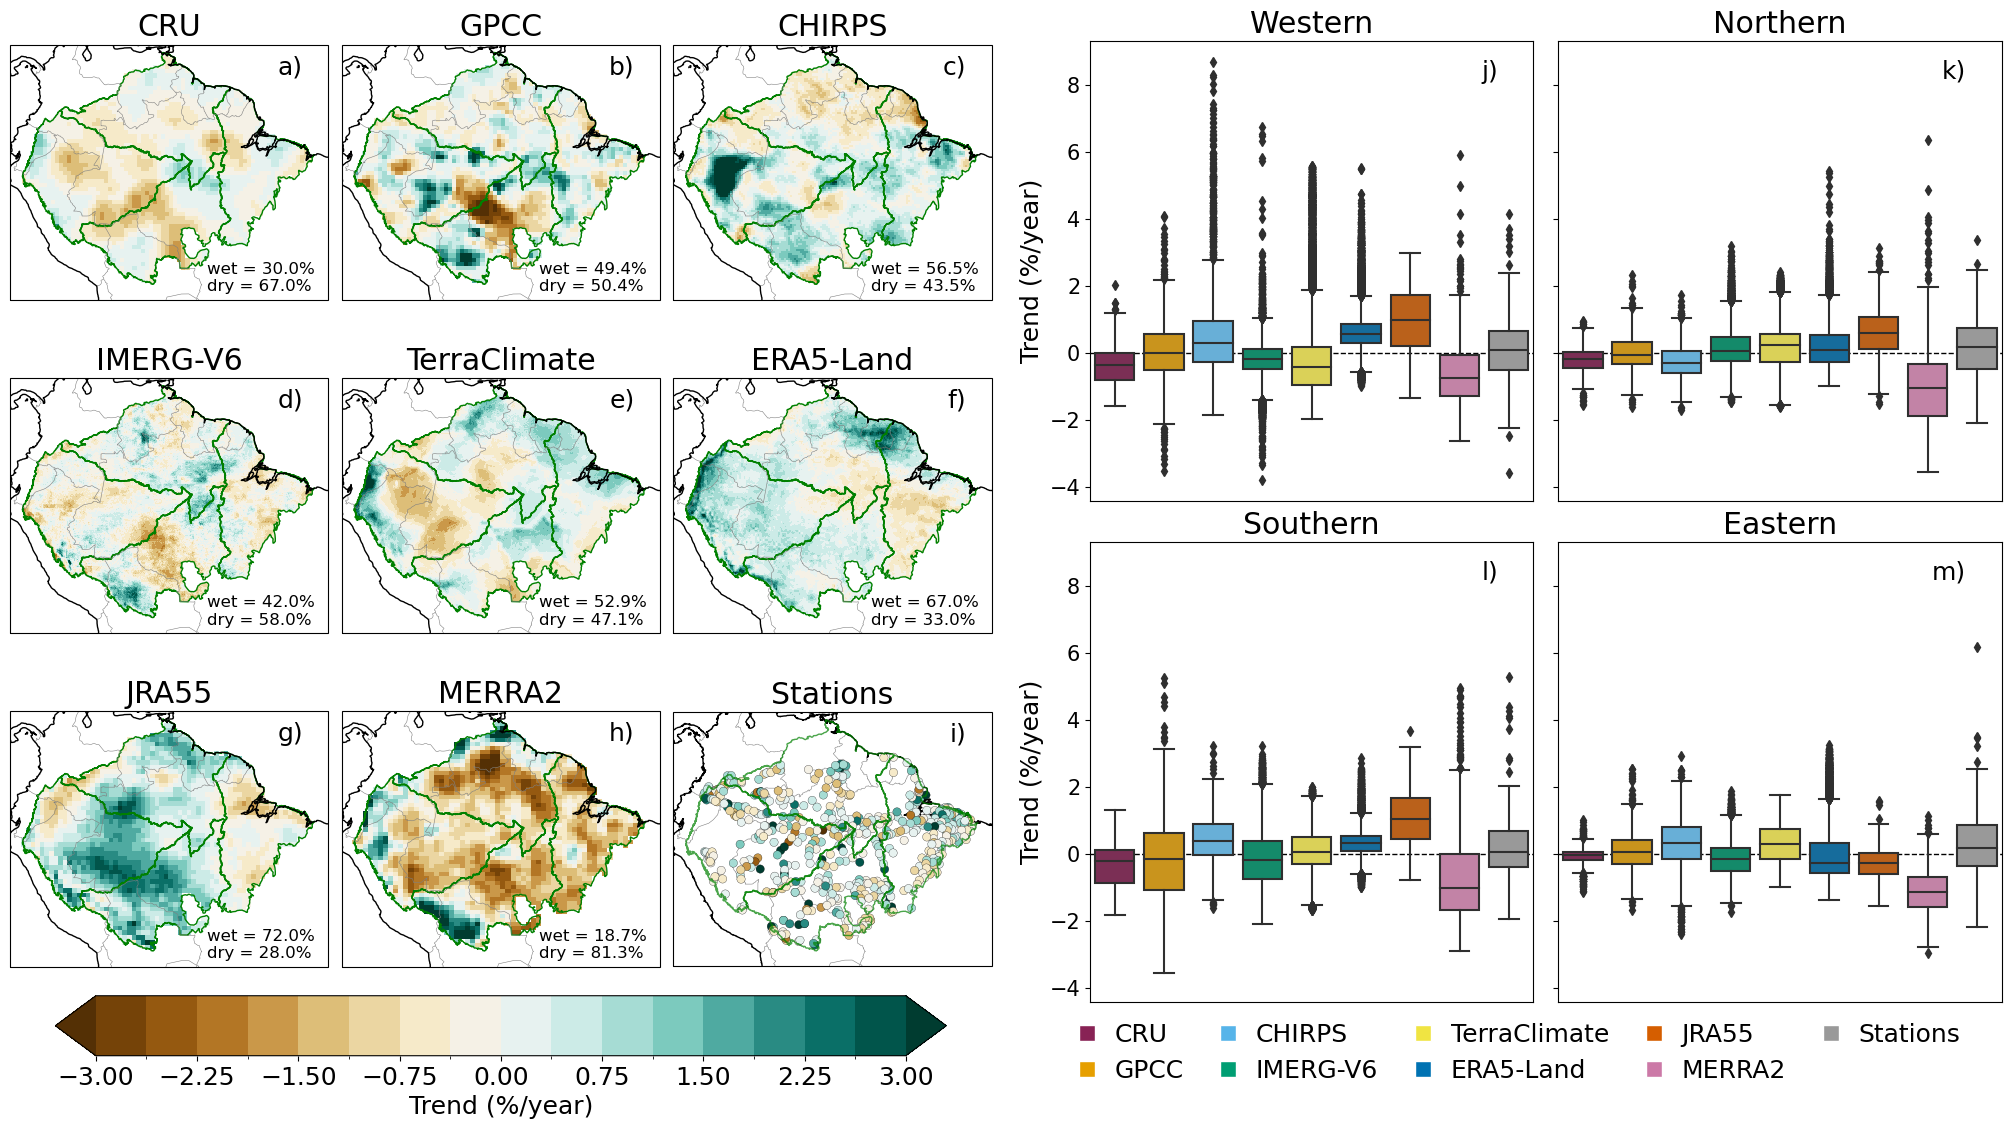

In [144]:
from Data.utils.datasets_plotting import plot_datasets33
letters_22 = ['j)', 'k)', 'l)', 'm)']

fig = plt.figure(layout='constrained', figsize=(20, 10))
subfigs = fig.subfigures(1, 2)
axs_right = subfigs[1].subplots(2, 2, sharex=True, sharey=True)
axs_right = axs_right.flatten()
for i, region in enumerate(regions_list):
    #boxplot of df
    axs_right[i].axhline(y=0, color='black', linestyle='--', linewidth=1, zorder= -10)
    sns.boxplot( y=var, data=df[df.Region==region], ax=axs_right[i], hue_order=hue_order, palette=wong, hue='Dataset',x='Dataset',dodge=False).get_legend().remove()
    axs_right[i].set_title(region)
    axs_right[i].set_xlabel('')
    axs_right[i].tick_params(axis='y', which='both', labelsize=15)
    axs_right[i].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    #horizontal line in 0
    if i % 2 == 0:
        axs_right[i].set_ylabel(label_cbar)
    else:
        axs_right[i].set_ylabel('')
    axs_right[i].text(0.92,0.96,  letters_22[i], transform=axs_right[i].transAxes,  fontsize=18, va='top', ha='right')

plot_datasets33(subfigs[0], datasets_names, ds_dict, stations, regions, vmin, vmax, levels, cmap, extend_cbar, var, var_stat, label_cbar)
#plot in each subplot in subfigs[0] the area that is drying or wetting
for j, name in enumerate(datasets_names):
    df_area = df_trend_area[df_trend_area.Dataset==name]
    subfigs[0].axes[j].annotate(f'wet = {df_area.Wet.values[0]}% \ndry = {df_area.Dry.values[0]}%', xy=(0.62, 0.15), xycoords='axes fraction', fontsize=12, va='top', ha='left')

#create legend in the bottom center of the figure
subfigs[1].legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.1), loc='lower center', ncol=5, frameon=False,handletextpad=0.1,columnspacing=0.8)

In [90]:
stattions_sig = stations[stations['p_anual'] <= 0.05]
ds_dict_sig = {}
for i, name in enumerate(datasets_names):
    data = ds_dict[name]
    dss = data.where(data['p_values'] <= 0.05)
    ds_dict_sig[name] = dss

df_sig = df[df['p_values'] <= 0.05]

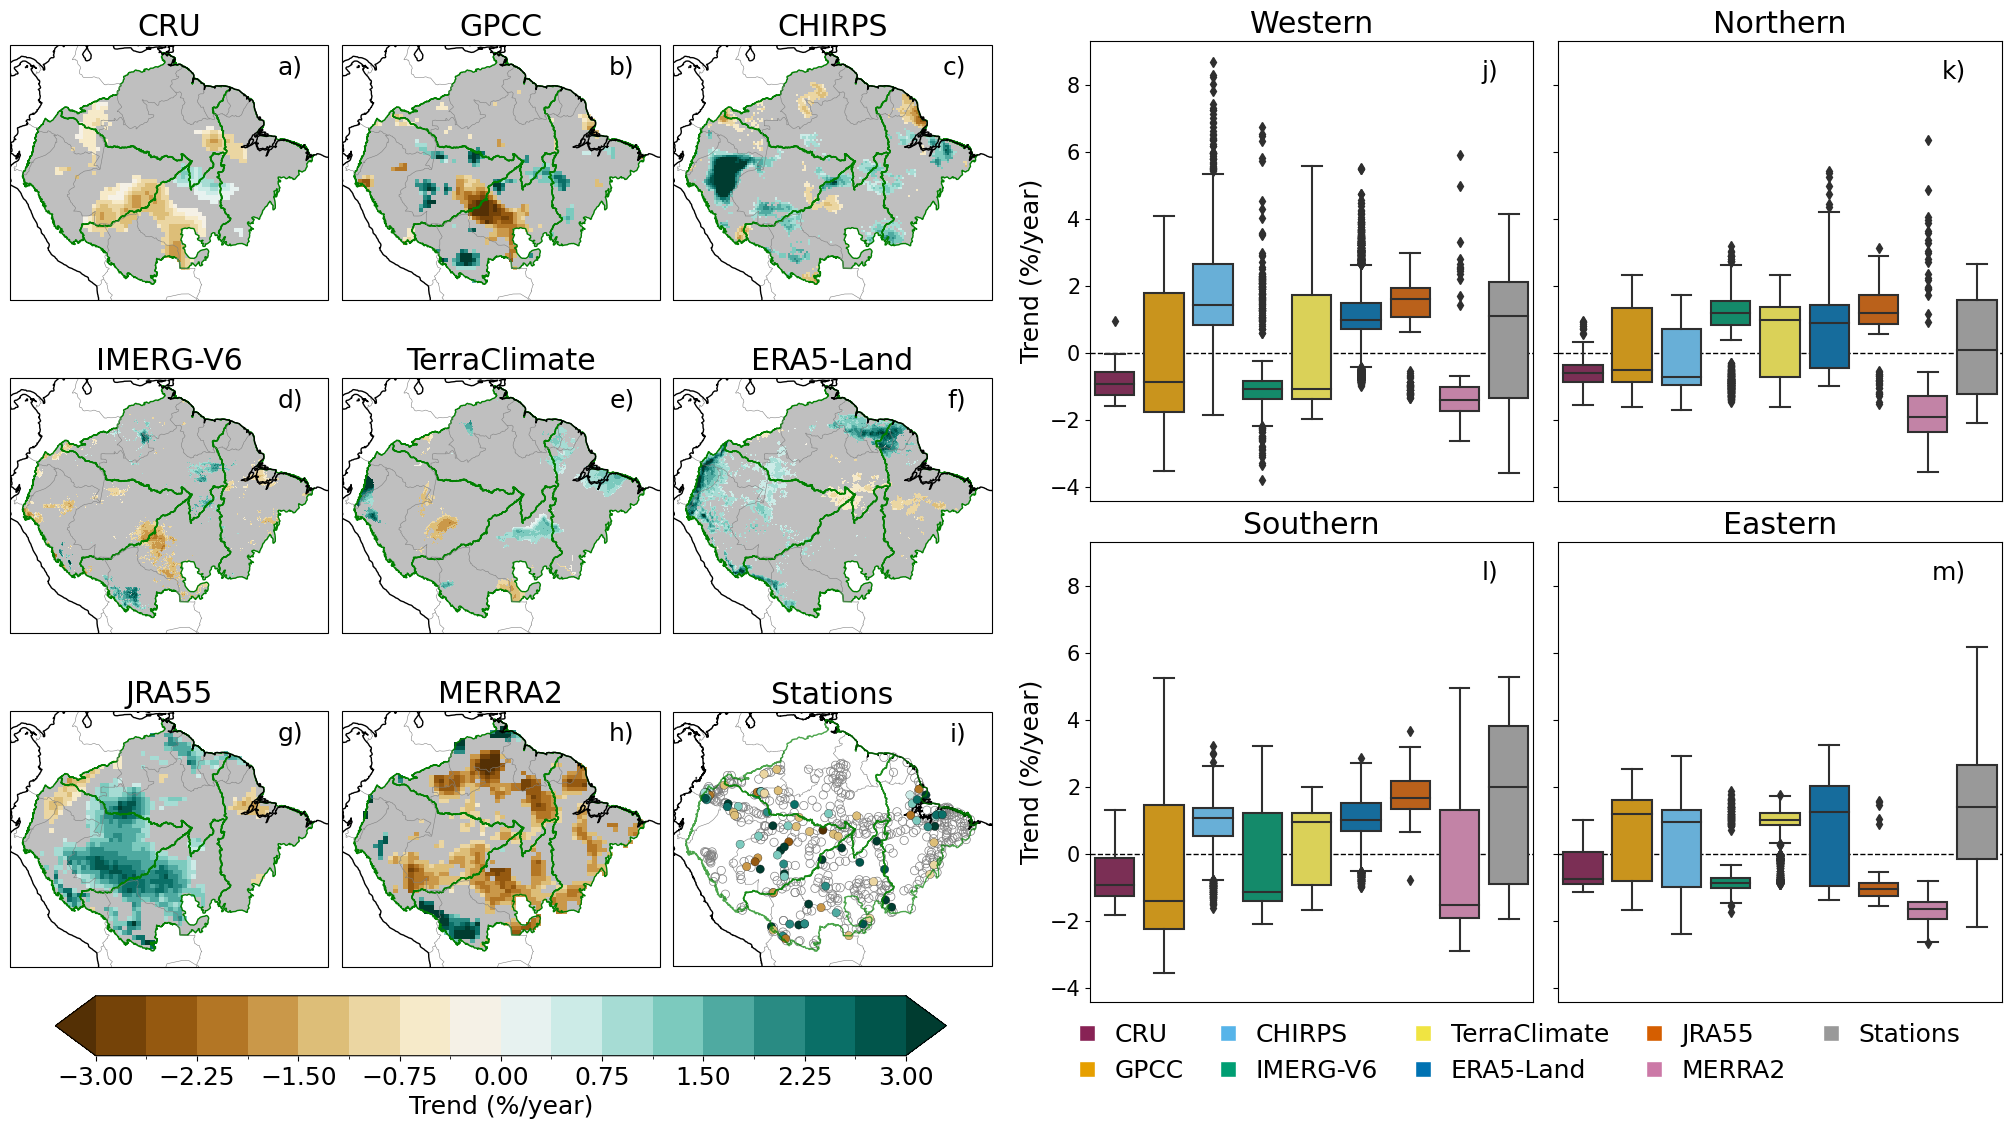

In [47]:
from Data.utils.datasets_plotting import plot_datasets33
fig = plt.figure(layout='constrained', figsize=(20, 10))
subfigs = fig.subfigures(1, 2)
axs_right = subfigs[1].subplots(2, 2, sharex=True, sharey=True)
axs_right = axs_right.flatten()
letters_22 = ['j)', 'k)', 'l)', 'm)']
for i, region in enumerate(regions_list):
    #boxplot of df
    axs_right[i].axhline(y=0, color='black', linestyle='--', linewidth=1, zorder= -10)

    sns.boxplot( y=var, data=df_sig[df_sig.Region==region], ax=axs_right[i], hue_order=hue_order, palette=wong, hue='Dataset',x='Dataset',dodge=False).get_legend().remove()
    axs_right[i].set_title(region)
    axs_right[i].set_xlabel('')
    axs_right[i].tick_params(axis='y', which='both', labelsize=15)
    axs_right[i].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    #horizontal line in 0
    if i % 2 == 0:
        axs_right[i].set_ylabel(label_cbar)
    else:
        axs_right[i].set_ylabel('')
    axs_right[i].text(0.92,0.96,  letters_22[i], transform=axs_right[i].transAxes,  fontsize=18, va='top', ha='right')

plot_datasets33(subfigs[0], datasets_names, ds_dict_sig, stattions_sig , regions, vmin, vmax, levels, cmap, extend_cbar, var, var_stat, label_cbar)

for i, ax in enumerate(subfigs[0].axes):
    if i <= 8:
        if i == 8:
            stations[stations['p_anual'] >= 0.05].plot(ax=ax, facecolor='none', linewidth=0.5, edgecolor='grey',zorder=-10)
        else:    
            ax.add_geometries(shp_pan.geometry, crs=ccrs.PlateCarree(), facecolor='grey', edgecolor='black', linewidth=0.1, zorder=-10, alpha=0.5)
    
    
   


#create legend in the bottom center of the figure
subfigs[1].legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.1), loc='lower center', ncol=5, frameon=False,handletextpad=0.1,columnspacing=0.8)

# hatch

In [174]:
#import mpatches
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerTuple


In [190]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.colors as colors
import matplotlib.cm as cm
plt.rcParams.update({'font.size': 18})
legend_elements_sig = [ (mpatches.Patch(facecolor='grey', edgecolor='black', hatch='///'),
                        Line2D([0], [0],  marker='o', color='w', markerfacecolor='grey', markersize=12, markeredgewidth=1.5, markeredgecolor='black')),
                          (mpatches.Patch(facecolor='grey', edgecolor='black'),
                           Line2D([0], [0],  marker='o', color='w', markerfacecolor='none', markersize=12, markeredgecolor='black', markeredgewidth=1.5))]
def plot_datasets33_trend_sig(subfigg, datasets_names, ds_dict, stations, regions, vmin, vmax, levels, cmap, extend_cbar, var, var_stat, label_cbar, extent=[-81, -42, -20, 11], proj=ccrs.Mercator(), ms=40):
    """
    Plot multiple datasets along with station and regional data on a grid of subplots.

    Parameters:
        datasets_names (list): A list of dataset names to plot.
        ds_dict (dict): A dictionary containing datasets with keys as dataset names and values as data arrays.
        stations (geopandas.GeoDataFrame): A GeoDataFrame containing station data.
        regions (geopandas.GeoDataFrame): A GeoDataFrame containing regional data.
        vmin (float): Minimum value for the color scale.
        vmax (float): Maximum value for the color scale.
        levels (int): Number of levels in the color scale.
        proj (cartopy.crs.Projection): The projection for the subplots.
        cmap (matplotlib.colors.Colormap): The colormap for the plots.
        extend_cbar (str): The colorbar extension ('min', 'max', or 'both').
        var (str): The variable key in the datasets to plot.
        var_stat (str): The variable key in the station GeoDataFrame to plot.
        extent (list): The geographical extent of the plot [min_lon, max_lon, min_lat, max_lat].
        label_cbar (str): Label for the colorbar.

    Returns:
        None

    Example:
        # Define the required variables
        vmin = -400
        vmax = 0.01
        levels = 9
        proj = ccrs.Mercator()
        cmap = cm.lajolla
        extend_cbar = 'min'
        var = 'mcwd'
        var_stat = 'mcwd'
        extent = [-81, -42, -20, 11]
        label_cbar = 'Maximum Cumulative Water Deficit (mm)'

        # Call the function to plot the datasets
        plot_datasets(datasets_names, ds_dict, stations, regions, vmin, vmax, levels, proj, cmap, extend_cbar, var, var_stat, extent, label_cbar)
    """
   
    
    bounds = np.linspace(vmin, vmax, levels)
    norm = colors.BoundaryNorm(bounds, cmap.N, extend=extend_cbar)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []
    
    axes = subfigg.subplots(3, 3, subplot_kw={'projection': proj})
    axes = axes.flatten()
    # Color bar
    cax = subfigg.add_axes([0.05, -0.12, 0.9, 0.06])
    subfigg.colorbar(sm, cax=cax, orientation='horizontal', label=label_cbar)
    
    # Loop through the datasets and plot them
    for i, name in enumerate(datasets_names):
        ax = axes[i]
        ds = ds_dict[name]
        im = ds[var].plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), levels=levels, extend=extend_cbar)
        ds[var].where(ds.p_values <= 0.05).plot.contourf(ax=ax, colors='none', hatches=['///'], add_colorbar=False,transform=ccrs.PlateCarree())
        ax.add_geometries(regions.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='green', linewidth=1)
        ax.add_feature(cf.BORDERS, edgecolor='grey', linewidth=0.4)
        axes[i].set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.coastlines()
        ax.set_title(name)
    
    ax_stat = axes[-1]
    ax_stat.coastlines(transform=ccrs.PlateCarree())
    ax_stat.add_geometries(cf.BORDERS.geometries(), crs=proj, linewidth=0.4, edgecolor='grey', facecolor='none', zorder=0)
    ax_stat.add_geometries(cf.COASTLINE.geometries(), crs=proj, linewidth=1, edgecolor='black', facecolor='none', zorder=0)
    #stations.plot(ax=ax_stat, column=var_stat, cmap=cmap, scheme="User_Defined",
    #              classification_kwds=dict(bins=bounds), linewidth=0.2, edgecolor='black')
    stations[stations.p_anual > 0.05].plot(edgecolor=cmap(norm(stations[var_stat].values)), linewidth=1.5, marker='o', markersize=ms,
                                           legend=False,facecolor='none',ax=ax_stat)    

    stations[stations.p_anual <= 0.05].plot( column=var_stat, cmap=cmap, scheme="User_Defined", markersize=ms*1.2,
                  classification_kwds=dict(bins=bounds), linewidth=0.2, edgecolor='black',ax=ax_stat)
    #create legend of significant and non-significant stations and plot it in the lower right corner

    subfigg.legend(handles=legend_elements_sig,labels=[r'p <= 0.05', 'p > 0.05'],handler_map={tuple: HandlerTuple(ndivide=None)},
                    bbox_to_anchor=(0.5, -0.06), loc='lower center', ncol=2, frameon=False, fontsize=15)
    ax_stat.set_title('Stations')
    regions.plot(ax=ax_stat, facecolor='none', edgecolor='green', linewidth=1, alpha=0.7)
    ax_stat.set_xlim(extent[0], extent[1])
    ax_stat.set_ylim(extent[2], extent[3])

    letters = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)']
    for i in range(len(datasets_names)+1):
        axes[i].text(0.92,0.96,  letters[i], transform=axes[i].transAxes,  fontsize=18, va='top', ha='right')


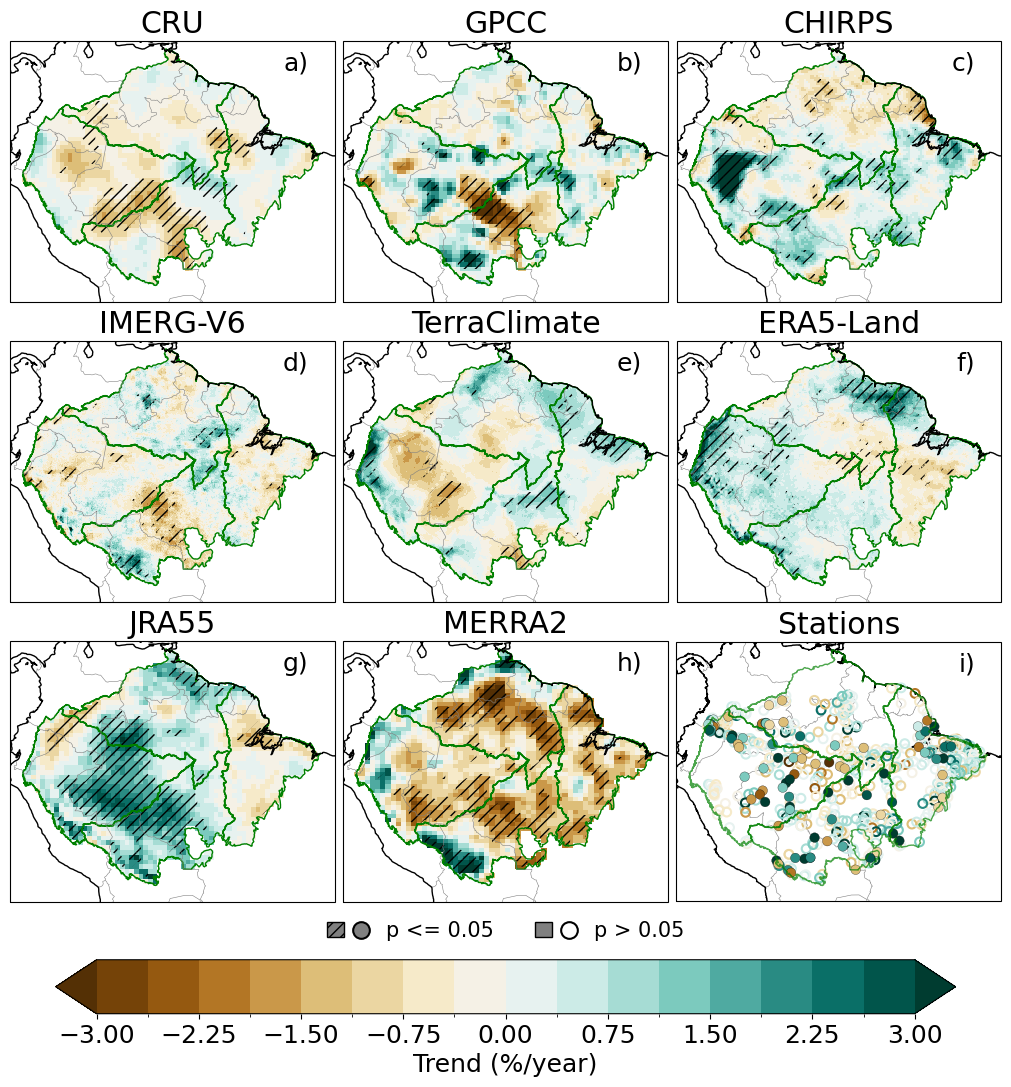

In [191]:
from Data.utils.datasets_plotting import plot_datasets33

fig = plt.figure(layout='constrained', figsize=(10, 9))
plot_datasets33_trend_sig(fig, datasets_names, ds_dict, stations, regions, vmin, vmax, levels, cmap, extend_cbar, var, var_stat, label_cbar)


In [186]:
#create a significant column for df
df['Significancy'] = df['p_values'] <= 0.05
df['Significancy'].replace({True: 'Significant', False: 'Not Significant'}, inplace=True)
df_all = df.copy()
df_all['Significancy'] = 'All'
df_sig = df[df['Significancy'] == 'Significant']
df_all = pd.concat([df_all, df_sig])

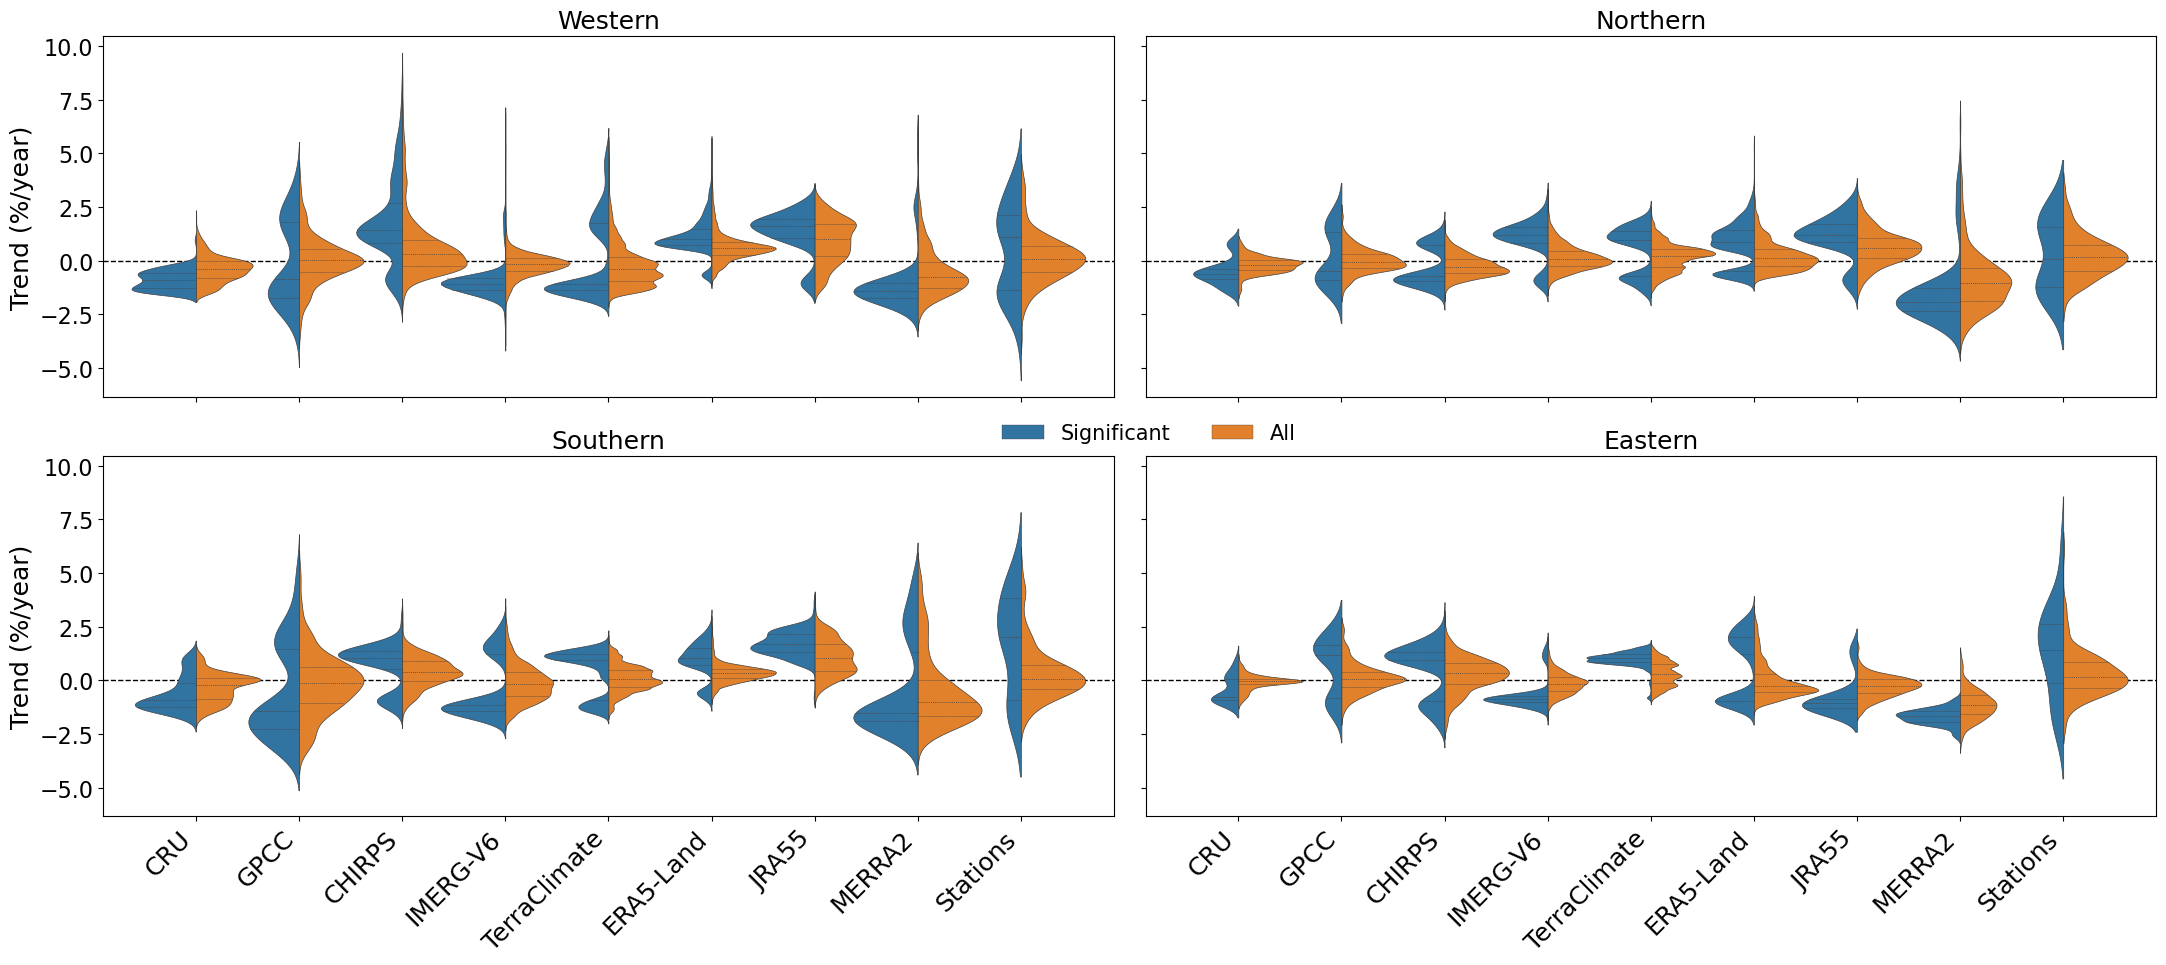

In [189]:
#plot violinplot of df_all with significant column for each region and dataset
fig, axes = plt.subplots(2,2, figsize=(22,10), sharex=True, sharey=True)
#font size as 12
plt.rcParams.update({'font.size': 18})
axes = axes.flatten()
for i, region in enumerate(regions_list):
    ax = axes[i]
    sns.violinplot(data=df_all[df_all.Region==region], x='Dataset', y=var, hue='Significancy', 
                   hue_order=['Significant', 'All'], ax=ax, split=True,  
                   linewidth=0.5,width=1.25, inner='quartile',scale='area')
    ax.set_title(region, fontsize=18)
    #set x lim 
    ax.set_xlim(-0.9, 8.9)
    ax.set_xlabel('')
    ax.set_ylabel('')
    #leave only the legend for last subplot
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()

    ax.tick_params(axis='y', which='both', labelsize=16)
    #set ticks label 45 degrees
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    #horizontal line in 0
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, zorder= -10)
    if i % 2 == 0:
        ax.set_ylabel(label_cbar, fontsize=18)
    else:
        ax.set_ylabel('')

#take the legend from axes[3], to figure and place it in the centeer
handles, labels = axes[3].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.53, 0.52), loc='lower center', ncol=2, frameon=False, fontsize=15)
plt.tight_layout()


# point comparinson

In [50]:
stations['trend_ratio'] = stations['slope_anual'] / stations['intercept_anual'] * 100
data = stations[['geometry','slope_anual','trend_ratio']].copy()
data = data.rename(columns={'slope_anual':'slopes'})
data['lon'] = data['geometry'].apply(lambda p: p.x)
data['lat'] = data['geometry'].apply(lambda p: p.y)
data = data.drop(columns=['geometry'])
var = 'trend_ratio'

In [51]:
metrics_dict = {}
for name in datasets_names:
    ds = ds_dict[name].copy()
    # Step 2: Assign each point to the grid cells of the 'ds' DataArray
    ds_grid_lon, ds_grid_lat = ds.lon.values, ds.lat.values
    data['lon_bin'] = np.digitize(data['lon'], ds_grid_lon)
    data['lat_bin'] = np.digitize(data['lat'], ds_grid_lat)
    for var in ['trend_ratio', 'slopes']:

        # Step 3: Compute the mean value for each grid cell and each year
        grid_cells = data.groupby(['lat_bin', 'lon_bin'])[var].mean().reset_index()
        # Step 4: Create an empty DataArray with NaN values
        empty_grid = np.full((len(ds_grid_lat), len(ds_grid_lon)), np.nan)
        # Step 5: Fill the DataArray with the computed mean values for each year
        for _, row in grid_cells.iterrows():
            #year_idx = np.where(data['year'].unique() == row['year'])[0][0]
            lat_idx, lon_idx = row['lat_bin'], row['lon_bin']
            lat_idx, lon_idx = int(lat_idx), int(lon_idx)
            empty_grid[lat_idx - 1, lon_idx - 1] = row[var]
        # Step 6: Create an xarray DataArray from the result with the year dimension
        #year_coords = data['year'].unique()
        data_array = xr.DataArray(empty_grid,
                                    dims=('lat', 'lon'),
                                    coords={'lat': ds_grid_lat, 'lon': ds_grid_lon})
        # Calculate various metrics
        ds[var + '_stat'] = data_array
    metrics_dict[name] = ds

In [52]:
df_compare = pd.DataFrame()
for name in datasets_names:
    df_comparef =  metrics_dict[name].to_dataframe().dropna().reset_index(drop=True)
    df_comparef['Dataset'] = name
    df_compare = df_compare.append(df_comparef)

df_compare = df_compare[['p_values', 'Region', 'Dataset','trend_ratio', 'trend_ratio_stat', 'slopes','slopes_stat']]
df_compare['Region'] = df_compare['Region'].replace(regions_replace)
#create significant column, if the row has pvalue less than 0.05 is significant
df_compare['significant'] = df_compare['p_values'] < 0.05
df_compare['significant'].replace({True: 'Significant', False: 'Not Significant'}, inplace=True)


C:\Users\luisg\AppData\Local\Temp\ipykernel_21616\3922144501.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compare = df_compare.append(df_comparef)
C:\Users\luisg\AppData\Local\Temp\ipykernel_21616\3922144501.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compare = df_compare.append(df_comparef)
C:\Users\luisg\AppData\Local\Temp\ipykernel_21616\3922144501.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compare = df_compare.append(df_comparef)
C:\Users\luisg\AppData\Local\Temp\ipykernel_21616\3922144501.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compare = df_compare.append(df_comparef)
C:\Users\luisg\A

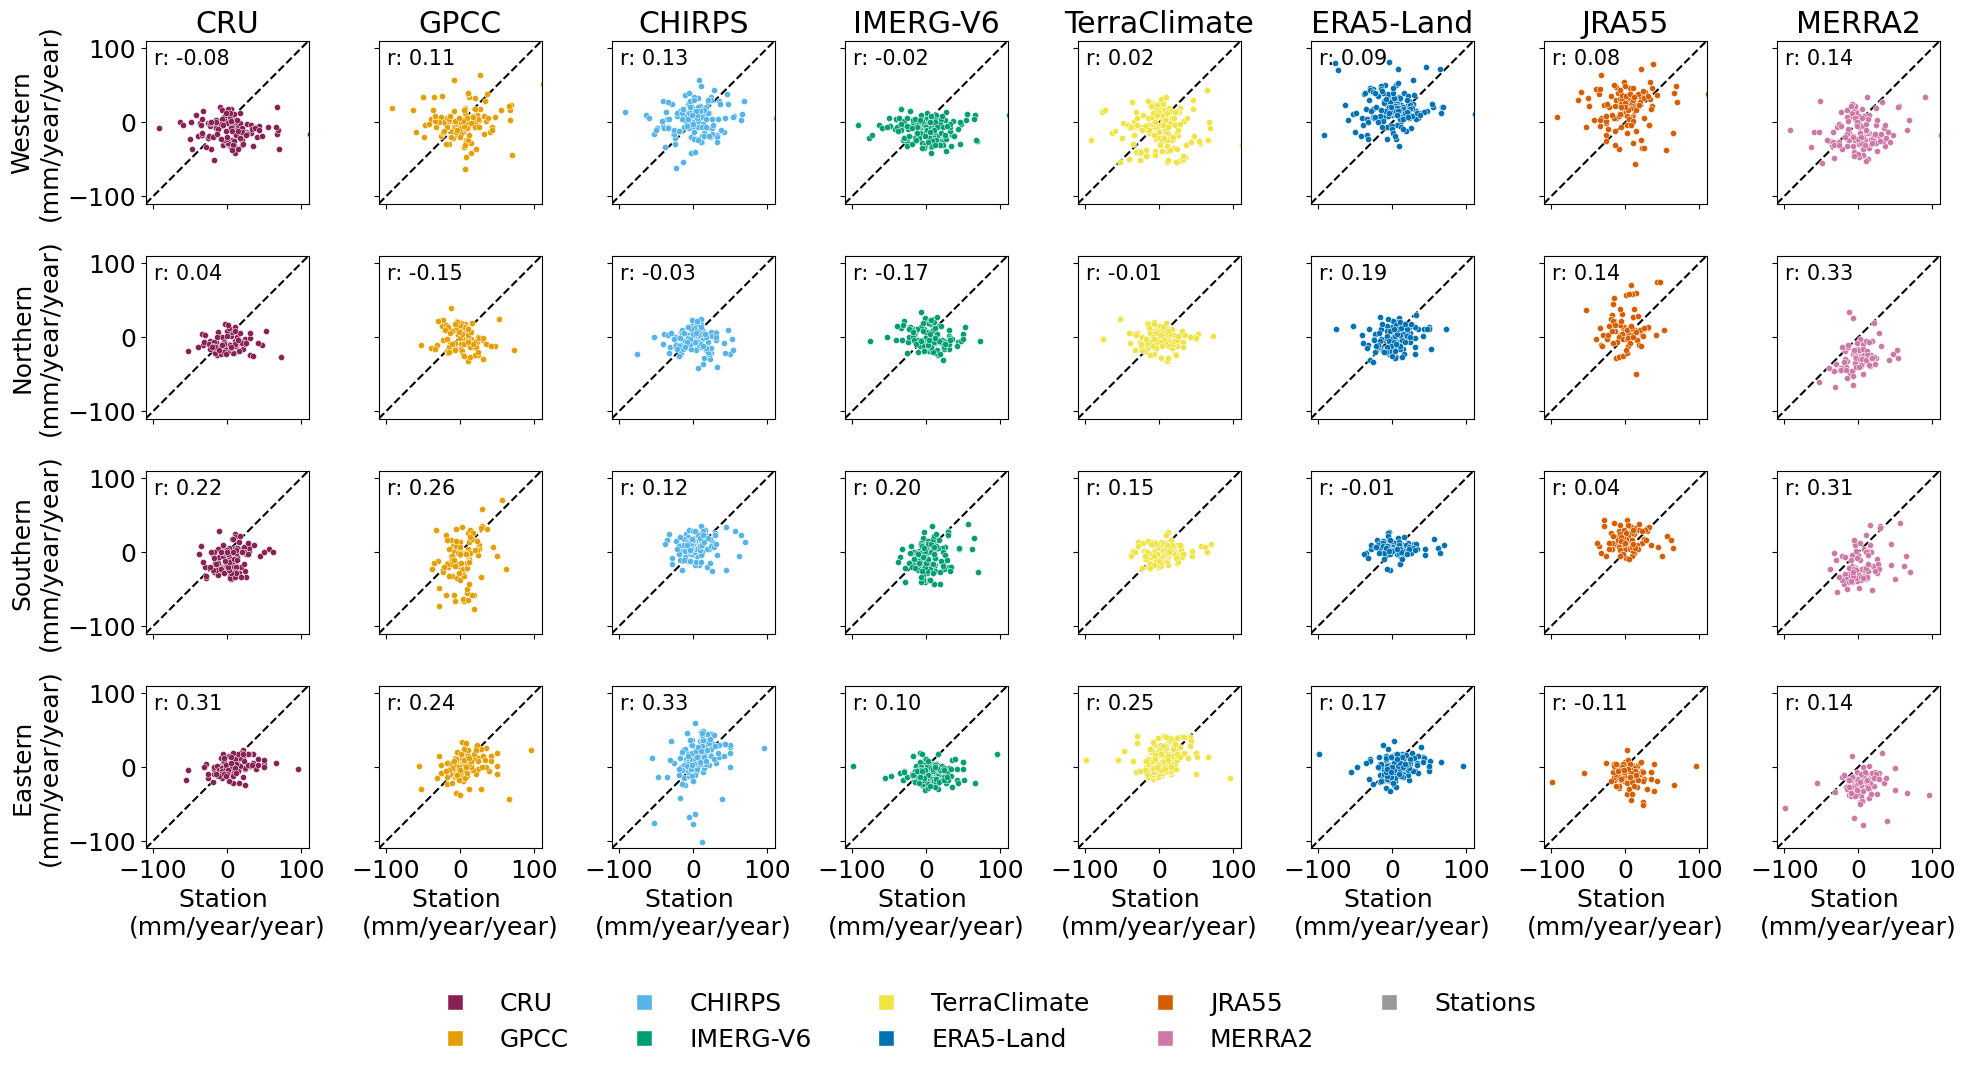

In [53]:
fig, axes = plt.subplots(4,8, figsize=(20,10), sharex=True, sharey=True)
limm = 110
for i, name in enumerate(datasets_names):
    df_ds = df_compare[df_compare['Dataset'] == name]
    for j, region in enumerate(regions_list):
        df_plot = df_ds[df_ds['Region'] == region]
        sns.scatterplot(data=df_plot,x='slopes_stat', y='slopes', ax=axes[j,i], s=20, color=wong[i], legend=False)
        
        axes[j,i].set_xlabel('Station \n(mm/year/year)')
        axes[j,i].set_ylabel(region + '\n(mm/year/year)')
        axes[j,i].set_xlim(-limm,limm)
        axes[j,i].set_ylim(-limm,limm)
        axes[j,i].plot([-limm,limm],[-limm,limm], color='black', linestyle='--',zorder=-30)
        axes[j,i].set_aspect('equal', 'box')
        corr = df_plot['slopes_stat'].corr(df_plot['slopes'])
        axes[j,i].text(0.05, 0.95, f'r: {corr:.2f}', transform=axes[j,i].transAxes, fontsize=15, verticalalignment='top')
    axes[0,i].set_title(name)
    #calculate the Coefficient of determination
    #axes[7].legend(bbox_to_anchor=(0.5, -0.limm), loc='lower center', ncol=3, frameon=False, fontsize=1limm)

    
    
fig.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.1), loc='lower center', ncol=5, frameon=False)
plt.tight_layout()

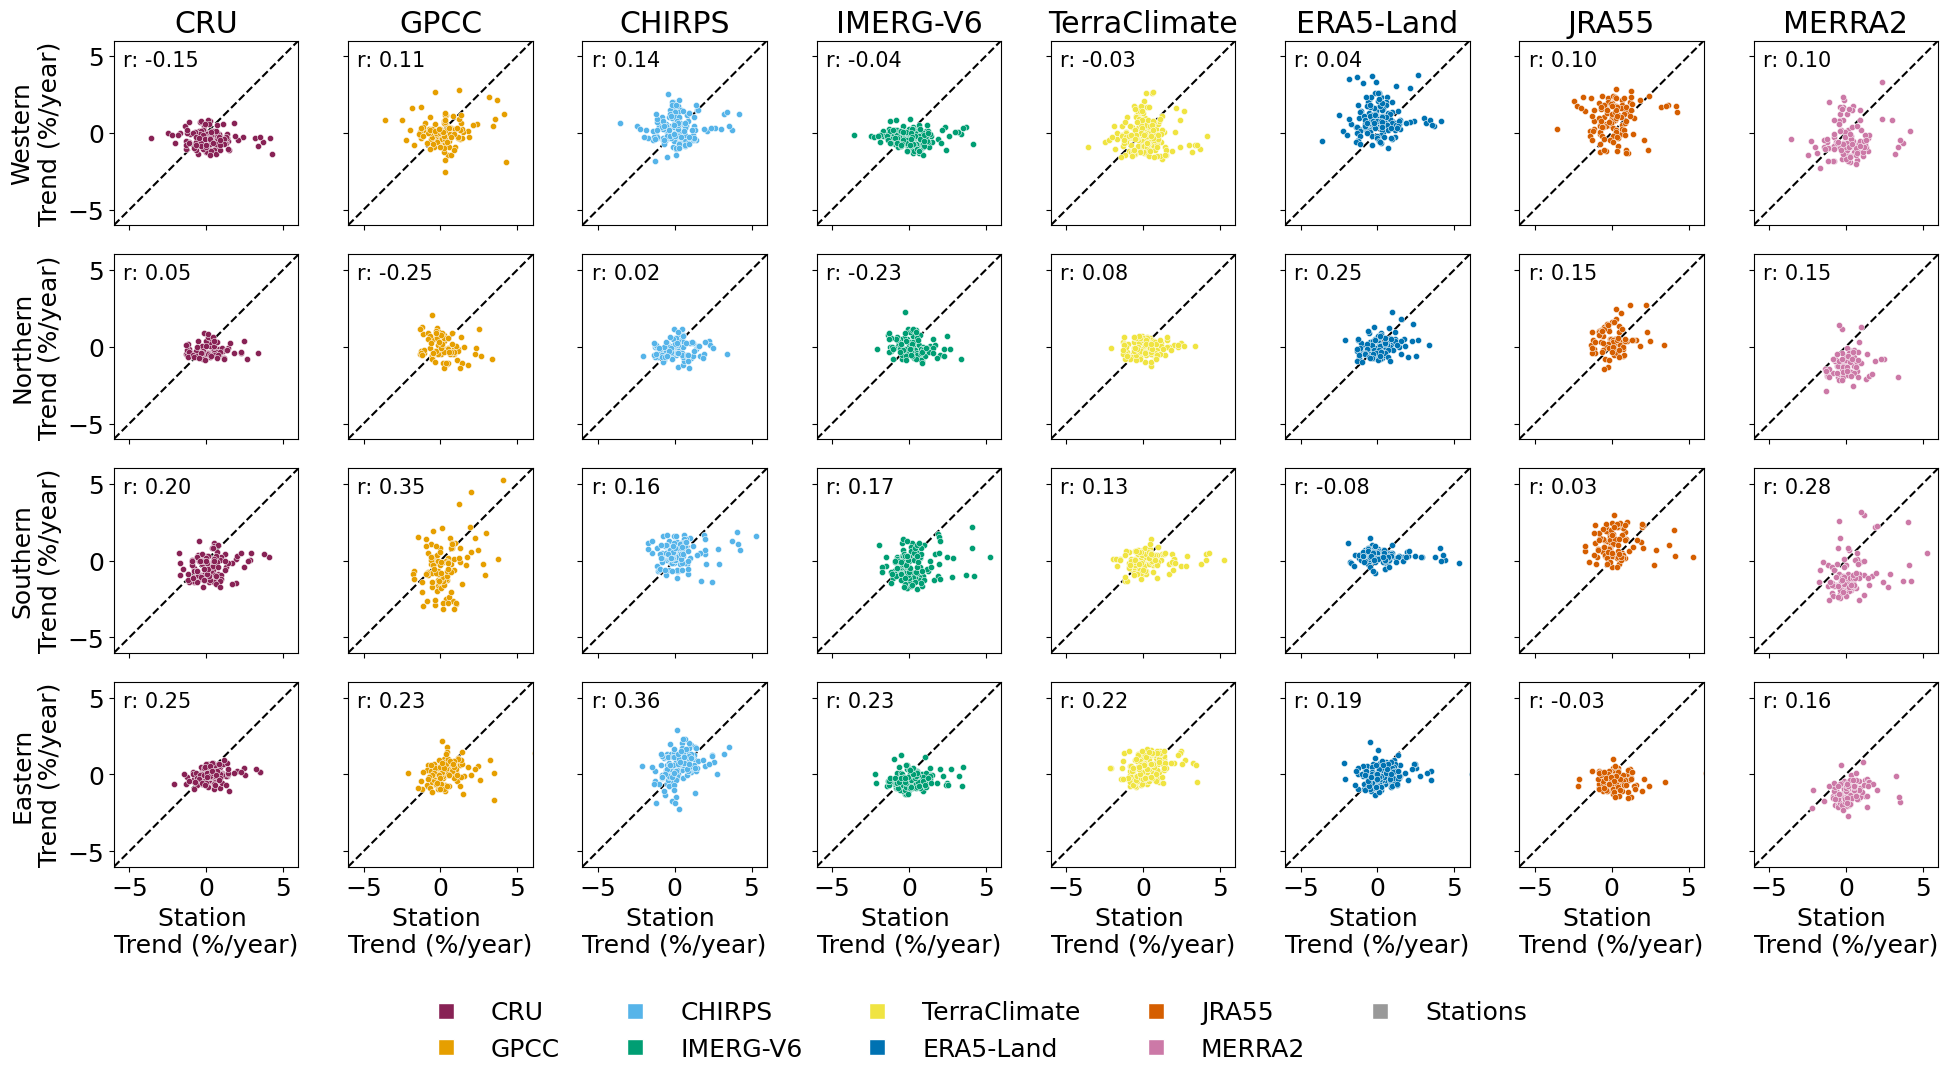

In [54]:
fig, axes = plt.subplots(4,8, figsize=(20,10), sharex=True, sharey=True)
limm = 6
for i, name in enumerate(datasets_names):
    df_ds = df_compare[df_compare['Dataset'] == name]
    for j, region in enumerate(regions_list):
        df_plot = df_ds[df_ds['Region'] == region]
        sns.scatterplot(data=df_plot,x='trend_ratio_stat', y='trend_ratio', ax=axes[j,i], s=20, color=wong[i], legend=False)
        
        axes[j,i].set_xlabel('Station \nTrend (%/year)')
        axes[j,i].set_ylabel(region + '\nTrend (%/year)')
        axes[j,i].set_xlim(-limm,limm)
        axes[j,i].set_ylim(-limm,limm)
        axes[j,i].plot([-limm,limm],[-limm,limm], color='black', linestyle='--',zorder=-30)
        axes[j,i].set_aspect('equal', 'box')
        corr = df_plot['trend_ratio_stat'].corr(df_plot['trend_ratio'])
        axes[j,i].text(0.05, 0.95, f'r: {corr:.2f}', transform=axes[j,i].transAxes, fontsize=15, verticalalignment='top')
    axes[0,i].set_title(name)
    #calculate the Coefficient of determination
    #axes[7].legend(bbox_to_anchor=(0.5, -0.limm), loc='lower center', ncol=3, frameon=False, fontsize=1limm)

    
    
fig.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.1), loc='lower center', ncol=5, frameon=False)
plt.tight_layout()

In [55]:
stations['trend_ratio'] = stations['slope_anual'] / stations['intercept_anual'] * 100
data = stations[['geometry','slope_anual','trend_ratio','p_anual']].copy()
data = data[data['p_anual'] <= 0.05]

data = data.rename(columns={'slope_anual':'slopes'})
data['lon'] = data['geometry'].apply(lambda p: p.x)
data['lat'] = data['geometry'].apply(lambda p: p.y)
data = data.drop(columns=['geometry'])
var = 'trend_ratio'
metrics_dict_sig = {}
for name in datasets_names:
    ds = ds_dict[name].copy()
    # Step 2: Assign each point to the grid cells of the 'ds' DataArray
    ds_grid_lon, ds_grid_lat = ds.lon.values, ds.lat.values
    data['lon_bin'] = np.digitize(data['lon'], ds_grid_lon)
    data['lat_bin'] = np.digitize(data['lat'], ds_grid_lat)
    for var in ['trend_ratio', 'slopes']:

        # Step 3: Compute the mean value for each grid cell and each year
        grid_cells = data.groupby(['lat_bin', 'lon_bin'])[var].mean().reset_index()
        # Step 4: Create an empty DataArray with NaN values
        empty_grid = np.full((len(ds_grid_lat), len(ds_grid_lon)), np.nan)
        # Step 5: Fill the DataArray with the computed mean values for each year
        for _, row in grid_cells.iterrows():
            #year_idx = np.where(data['year'].unique() == row['year'])[0][0]
            lat_idx, lon_idx = row['lat_bin'], row['lon_bin']
            lat_idx, lon_idx = int(lat_idx), int(lon_idx)
            empty_grid[lat_idx - 1, lon_idx - 1] = row[var]
        # Step 6: Create an xarray DataArray from the result with the year dimension
        #year_coords = data['year'].unique()
        data_array = xr.DataArray(empty_grid,
                                    dims=('lat', 'lon'),
                                    coords={'lat': ds_grid_lat, 'lon': ds_grid_lon})
        # Calculate various metrics
        ds[var + '_stat'] = data_array
    metrics_dict_sig[name] = ds


df_compare_sig = pd.DataFrame()
for name in datasets_names:
    df_compare_sigf =  metrics_dict_sig[name].to_dataframe().dropna().reset_index(drop=True)
    df_compare_sigf['Dataset'] = name
    df_compare_sig = df_compare_sig.append(df_compare_sigf)

df_compare_sig = df_compare_sig[['p_values', 'Region', 'Dataset','trend_ratio', 'trend_ratio_stat', 'slopes','slopes_stat']]
df_compare_sig['Region'] = df_compare_sig['Region'].replace(regions_replace)
#create significant column, if the row has pvalue less than 0.05 is significant
#df_compare_sig['significant'] = df_compare_sig['p_values'] < 0.05
#df_compare_sig['significant'].replace({True: 'Significant', False: 'Not Significant'}, inplace=True)
df_ss = df_compare_sig[df_compare_sig['p_values'] < 0.05]

C:\Users\luisg\AppData\Local\Temp\ipykernel_21616\542554302.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compare_sig = df_compare_sig.append(df_compare_sigf)
C:\Users\luisg\AppData\Local\Temp\ipykernel_21616\542554302.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compare_sig = df_compare_sig.append(df_compare_sigf)
C:\Users\luisg\AppData\Local\Temp\ipykernel_21616\542554302.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compare_sig = df_compare_sig.append(df_compare_sigf)
C:\Users\luisg\AppData\Local\Temp\ipykernel_21616\542554302.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compare_sig = df_comp

c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encoun

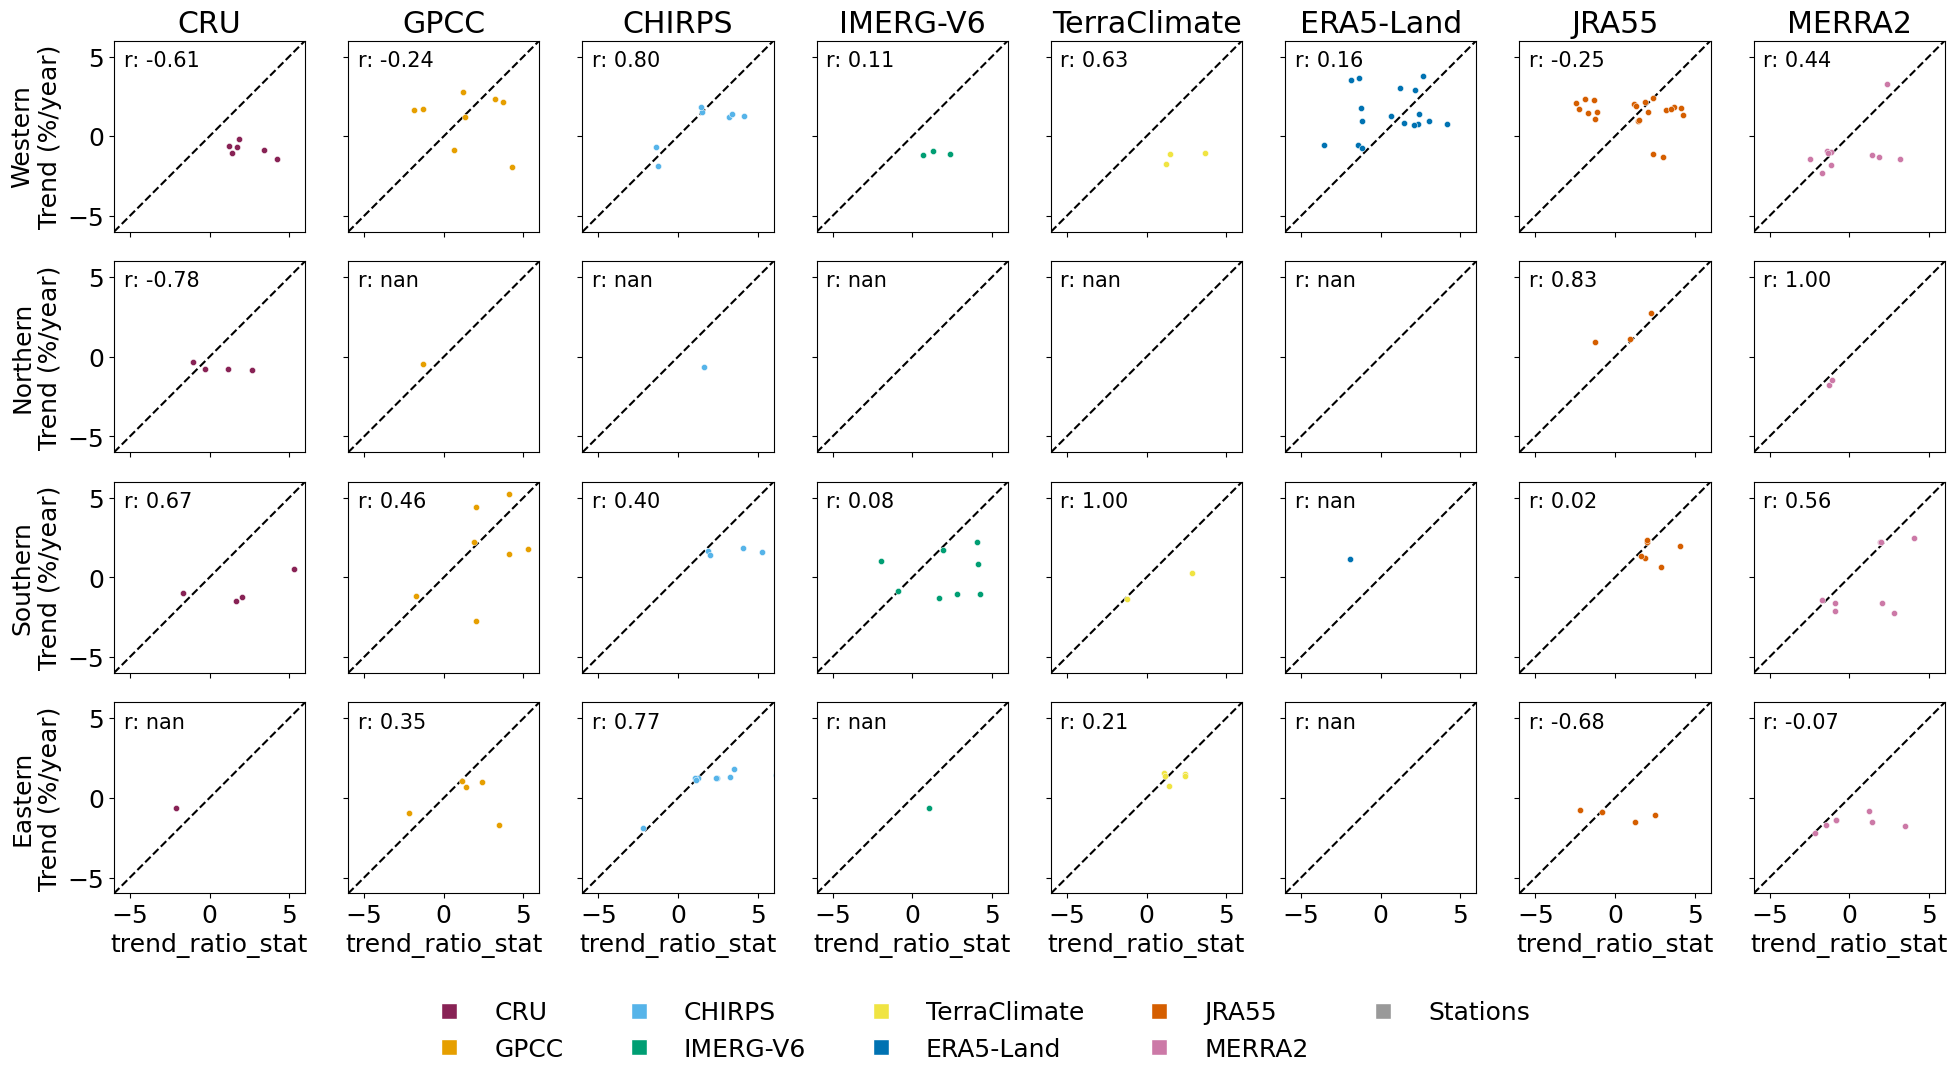

In [56]:
fig, axes = plt.subplots(4,8, figsize=(20,10), sharex=True, sharey=True)
limm = 6
for i, name in enumerate(datasets_names):
    df_ds = df_ss[df_ss['Dataset'] == name]
    for j, region in enumerate(regions_list):
        df_plot = df_ds[df_ds['Region'] == region]
        sns.scatterplot(data=df_plot,x='trend_ratio_stat', y='trend_ratio', ax=axes[j,i], s=20, color=wong[i], legend=False)
        
        axes[0,i].set_xlabel('Station \nTrend (%/year)')
        axes[j,0].set_ylabel(region + '\nTrend (%/year)')
        axes[j,i].set_xlim(-limm,limm)
        axes[j,i].set_ylim(-limm,limm)
        axes[j,i].plot([-limm,limm],[-limm,limm], color='black', linestyle='--',zorder=-30)
        axes[j,i].set_aspect('equal', 'box')
        corr = df_plot['trend_ratio_stat'].corr(df_plot['trend_ratio'])
        axes[j,i].text(0.05, 0.95, f'r: {corr:.2f}', transform=axes[j,i].transAxes, fontsize=15, verticalalignment='top')
    axes[0,i].set_title(name)
    #calculate the Coefficient of determination
    #axes[7].legend(bbox_to_anchor=(0.5, -0.limm), loc='lower center', ncol=3, frameon=False, fontsize=1limm)

    
    
fig.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.1), loc='lower center', ncol=5, frameon=False)
plt.tight_layout()

# area %

In [8]:
dff_list = []
for name in datasets_names:
    dss = ds_dict[name]
    #calculate the area that is drying or wetting in trend_ratio
    dss_total = dss['trend_ratio'].notnull().pipe(global_mean)
    #calculate area
    dss_dry = dss['trend_ratio'].where(dss['trend_ratio'] < 0).notnull().pipe(global_mean)
    dss_wet = dss['trend_ratio'].where(dss['trend_ratio'] > 0).notnull().pipe(global_mean)
    #calculate percentage
    dss_dry = dss_dry / dss_total * 100
    dss_wet = dss_wet / dss_total * 100
    #now dry and wet significant
    dss_dry_sig = dss['trend_ratio'].where((dss['trend_ratio'] < 0) & (dss['p_values'] < 0.05)).notnull().pipe(global_mean)
    dss_wet_sig = dss['trend_ratio'].where((dss['trend_ratio'] > 0) & (dss['p_values'] < 0.05)).notnull().pipe(global_mean)
    #calculate percentage
    dss_dry_sig = dss_dry_sig / dss_total * 100
    dss_wet_sig = dss_wet_sig / dss_total * 100
    #create a df with the results
    df_dry_wet = pd.DataFrame({'Dry':dss_dry.values.round(1), 'Wet':dss_wet.values.round(1), 'Dry_sig':dss_dry_sig.values.round(1), 'Wet_sig':dss_wet_sig.values.round(1), 'Dataset':name}, index=[0])
    #df_dry_wet['Dataset'] = name
    dff_list.append(df_dry_wet)
df_trend_area = pd.concat(dff_list).reset_index(drop=True)
df_trend_area

,Dry,Wet,Dry_sig,Wet_sig,Dataset
0,67.0,30.0,18.2,3.2,CRU
1,50.4,49.4,10.4,7.3,GPCC
2,43.5,56.5,6.6,16.4,CHIRPS
3,58.0,42.0,7.7,3.5,IMERG-V6
4,47.1,52.9,3.1,7.8,TerraClimate
5,33.0,67.0,3.9,16.5,ERA5-Land
6,28.0,72.0,5.5,35.0,JRA55
7,81.3,18.7,36.5,4.9,MERRA2


In [9]:
dff_list = []
for name in datasets_names:
    dss = ds_dict[name]
    dss['dry'] = dss['trend_ratio'].where(dss['trend_ratio'] < 0).notnull()
    dss['wet'] = dss['trend_ratio'].where(dss['trend_ratio'] > 0).notnull()
    dss['dry_sig'] = dss['trend_ratio'].where((dss['trend_ratio'] < 0) & (dss['p_values'] < 0.05)).notnull()
    dss['wet_sig'] =dss['trend_ratio'].where ((dss['trend_ratio'] > 0) & (dss['p_values'] < 0.05)).notnull()
    #calculate area
    ds_a = dss.groupby('Region').apply(global_mean)
    ds_a = ds_a[['dry', 'wet', 'dry_sig', 'wet_sig']] * 100
    dff = ds_a.to_dataframe().reset_index()
    dff['Dataset'] = name
    dff_list.append(dff)

df_trend_reg = pd.concat(dff_list).reset_index(drop=True)
df_trend_reg['Region'] = df_trend_reg['Region'].replace(regions_replace)
df_trend_reg = df_trend_reg[['Region', 'Dataset', 'dry', 'wet', 'dry_sig', 'wet_sig']].round(1)

df_stat['dry'] = df_stat['trend_ratio'] < 0
df_stat['wet'] = df_stat['trend_ratio'] > 0
df_stat['dry_sig'] = (df_stat['trend_ratio'] < 0) & (df_stat['p_values'] < 0.05)
df_stat['wet_sig'] = (df_stat['trend_ratio'] > 0) & (df_stat['p_values'] < 0.05)
#number of stations by region for dry and wet, etc
df_reg_t = df_stat.groupby('Region').sum()[['dry', 'wet', 'dry_sig', 'wet_sig']].astype(int)
#divide each row of df_reg_t for the total number of stations in each region
df_reg_t = df_reg_t.div(df_reg_t.sum(axis=1), axis=0) * 100
#round 1
df_reg_t.reset_index(inplace=True)
df_reg_t['Dataset'] = 'Stations'
#append in df_trend_reg
df_trend_reg = df_trend_reg.append(df_reg_t).reset_index(drop=True).round(1)
df_trend_reg

C:\Users\luisg\AppData\Local\Temp\ipykernel_14916\3835063082.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_reg_t = df_stat.groupby('Region').sum()[['dry', 'wet', 'dry_sig', 'wet_sig']].astype(int)
C:\Users\luisg\AppData\Local\Temp\ipykernel_14916\3835063082.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_trend_reg = df_trend_reg.append(df_reg_t).reset_index(drop=True).round(1)


,Region,Dataset,dry,wet,dry_sig,wet_sig
0,Southern,CRU,61.1,33.1,32.8,9.3
1,Eastern,CRU,58.9,35.4,5.4,2.8
2,Western,CRU,74.8,23.3,23.6,0.1
3,Northern,CRU,69.5,30.5,10.3,1.9
4,Southern,GPCC,55.0,45.0,22.2,11.7
5,Eastern,GPCC,43.6,56.4,3.7,7.5
6,Western,GPCC,49.3,50.7,13.0,9.0
7,Northern,GPCC,52.6,46.6,2.9,1.9
8,Southern,CHIRPS,26.2,73.8,5.9,18.1
9,Eastern,CHIRPS,32.7,67.2,8.1,17.5


In [10]:
dry = (df_stat['trend_ratio'] < 0).sum() / df_stat.shape[0] * 100
wet = (df_stat['trend_ratio'] > 0).sum() / df_stat.shape[0] * 100
dry_sig = ((df_stat['trend_ratio'] < 0) & (df_stat['p_values'] < 0.05)).sum() / df_stat.shape[0] * 100
wet_sig = ((df_stat['trend_ratio'] > 0) & (df_stat['p_values'] < 0.05)).sum() / df_stat.shape[0] * 100
df_trend_area = df_trend_area.append(pd.DataFrame({'dry':dry, 'wet':wet, 'dry_sig':dry_sig, 'wet_sig':wet_sig, 'Dataset':'Stations'}, index=[0]))
df_trend_area = df_trend_area.round(1)

C:\Users\luisg\AppData\Local\Temp\ipykernel_14916\3785449249.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_trend_area = df_trend_area.append(pd.DataFrame({'dry':dry, 'wet':wet, 'dry_sig':dry_sig, 'wet_sig':wet_sig, 'Dataset':'Stations'}, index=[0]))


In [11]:
dff_list = []
for name in datasets_names:
    dss = ds_dict[name]
    #calculate the area that is drying or wetting in trend_ratio
    dss_total = dss['trend_ratio'].notnull().pipe(global_mean)
    #calculate area
    dss_dry = dss['trend_ratio'].where(dss['trend_ratio'] < 0).notnull().pipe(global_mean)
    dss_wet = dss['trend_ratio'].where(dss['trend_ratio'] > 0).notnull().pipe(global_mean)
    #calculate percentage
    dss_dry = dss_dry / dss_total * 100
    dss_wet = dss_wet / dss_total * 100
    #now dry and wet significant
    dss_dry_sig = dss['trend_ratio'].where((dss['trend_ratio'] < 0) & (dss['p_values'] < 0.05)).notnull().pipe(global_mean)
    dss_wet_sig = dss['trend_ratio'].where((dss['trend_ratio'] > 0) & (dss['p_values'] < 0.05)).notnull().pipe(global_mean)
    #calculate percentage
    dss_dry_sig = dss_dry_sig / dss_total * 100
    dss_wet_sig = dss_wet_sig / dss_total * 100
    #create a df with the results
    df_dry_wet = pd.DataFrame({'dry':dss_dry.values, 'wet':dss_wet.values, 'dry_sig':dss_dry_sig.values, 'wet_sig':dss_wet_sig.values, 'Dataset':name}, index=[0])
    #df_dry_wet['Dataset'] = name
    dff_list.append(df_dry_wet)
df_trend_area = pd.concat(dff_list).reset_index(drop=True)
#calculate percentage of stations with drying or wetting trend
dry = (df_stat['trend_ratio'] < 0).sum() / df_stat.shape[0] * 100
wet = (df_stat['trend_ratio'] > 0).sum() / df_stat.shape[0] * 100
dry_sig = ((df_stat['trend_ratio'] < 0) & (df_stat['p_values'] < 0.05)).sum() / df_stat.shape[0] * 100
wet_sig = ((df_stat['trend_ratio'] > 0) & (df_stat['p_values'] < 0.05)).sum() / df_stat.shape[0] * 100
df_trend_area = df_trend_area.append(pd.DataFrame({'dry':dry, 'wet':wet, 'dry_sig':dry_sig, 'wet_sig':wet_sig, 'Dataset':'Stations'}, index=[0]))
df_trend_area = df_trend_area.round(1)
df_trend_area

C:\Users\luisg\AppData\Local\Temp\ipykernel_14916\74662138.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_trend_area = df_trend_area.append(pd.DataFrame({'dry':dry, 'wet':wet, 'dry_sig':dry_sig, 'wet_sig':wet_sig, 'Dataset':'Stations'}, index=[0]))


,dry,wet,dry_sig,wet_sig,Dataset
0,67.0,30.0,18.2,3.2,CRU
1,50.4,49.4,10.4,7.3,GPCC
2,43.5,56.5,6.6,16.4,CHIRPS
3,58.0,42.0,7.7,3.5,IMERG-V6
4,47.1,52.9,3.1,7.8,TerraClimate
5,33.0,67.0,3.9,16.5,ERA5-Land
6,28.0,72.0,5.5,35.0,JRA55
7,81.3,18.7,36.5,4.9,MERRA2
0,43.5,56.5,5.9,9.6,Stations


In [145]:
#create a list of 4 colors, 2 for dry and 2 for wet, dry brown and light brown, wet blue and light blue
colors = ['#8c510a', '#d8b365', '#5ab4ac', '#01665e']

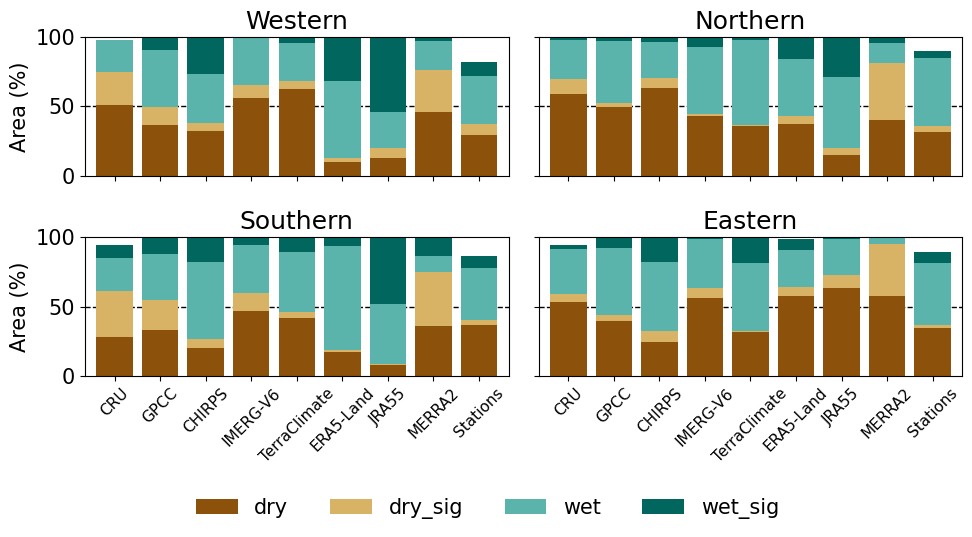

In [163]:
#now the same for df_trend_reg
df_trend_reg_plot = df_trend_reg.copy()
df_trend_reg_plot['dry'] = df_trend_reg_plot['dry'] - df_trend_reg_plot['dry_sig']
df_trend_reg_plot['wet'] = df_trend_reg_plot['wet'] - df_trend_reg_plot['wet_sig']
#change font size
plt.rcParams.update({'font.size': 15})
#but for each region
fig, axes = plt.subplots(2,2, figsize=(10,10), sharex=True, sharey=True)
axes = axes.flatten()
for i, region in enumerate(regions_list):
    df_reg = df_trend_reg_plot[df_trend_reg_plot['Region'] == region]
    df_reg.plot.bar(x='Dataset', y=['dry','dry_sig', 'wet','wet_sig'], stacked=True, figsize=(10,5), rot=45, width=0.8, color=colors, ax=axes[i])
    axes[i].set_title(region)
    axes[i].set_ylim(0,100)
    axes[i].set_ylabel('Area (%)')
    axes[i].set_xlabel('')
    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].get_legend().remove()
    #set ticks label font size
    axes[i].tick_params(axis='x', which='both', labelsize=11)
    #horizontal line in 50
    axes[i].axhline(y=50, color='black', linestyle='--', linewidth=1, zorder= -10)
fig.legend(handles, labels, bbox_to_anchor=(0.5, -0.1), loc='lower center', ncol=4, frameon=False)
plt.tight_layout()